In [47]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')


def mean_absolute_percentage_error(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_model(model_name, model, X, y):
    
    predictions = model.predict(X)

    MAE = mean_absolute_error(y, predictions)
    MAPE = mean_absolute_percentage_error(y, predictions)
    RMSE = mean_squared_error(y, predictions, squared = False)
    R2 = r2_score(y, predictions)

    print('MAE for', model_name, ': %1.3f' % MAE)
    print('MAPE for', model_name, ': %1.3f' % MAPE)
    print('RMSE for', model_name, ': %1.3f' % RMSE)
    print('R2 for', model_name, ': %1.3f' % R2)
    
    
def plot_predictions(model, x, y, title):
    
    plt.figure(figsize = (7, 4))
    sns.scatterplot(x = y, y = model.predict(x), s = 20)
    sns.lineplot([y.min(), y.max()], [y.min(), y.max()], color = 'black', linewidth = 1)
    plt.title(title + '\n')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()

In [2]:
city = 'venezia'

listings_link = 'data/' + city + '/listings_modeling.csv'
listings = pd.read_csv(listings_link)

In [29]:
drop_other_score_features = listings.filter(like = 'score').columns
drop_other_score_features = [i for i in drop_other_score_features if i != 'review_scores_rating']
print('Dropping: ', drop_other_score_features)

listings.drop(drop_other_score_features, 1, inplace = True)

Dropping:  ['review_scores_accuracy', 'review_scores_cleanliness']


Train test split

In [30]:
y = listings['review_scores_rating']
X = listings.drop('review_scores_rating', 1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20202020, train_size = 0.8)

Categorical features - gmbs can handle them without one hot encoding

In [31]:
categorical_features = X.select_dtypes(include = 'O').columns.tolist()
print(categorical_features)

['host_response_time', 'room_type', 'neighbourhood_cleansed_grouped']


## 1. Baseline default CatBoost

In [79]:
default_model = CatBoostRegressor(random_state = 20202020, 
                                  learning_rate = 0.05,
                                  rsm = 1,
                                  min_data_in_leaf = 100,
                                  l2_leaf_reg = 5,
                                  iterations = 1000,
                                  # early_stopping_rounds = 15,
                                  cat_features = categorical_features,
                                  one_hot_max_size = 20,
                                  verbose = 100)
default_model.fit(X_train, y_train, eval_set = (X_test, y_test), plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [80]:
evaluate_model('Default CatBoost on train', default_model, X_train, y_train)

MAE for Default CatBoost on train : 0.106
MAPE for Default CatBoost on train : 2.383
RMSE for Default CatBoost on train : 0.148
R2 for Default CatBoost on train : 0.803


In [81]:
evaluate_model('Default CatBoost on test', default_model, X_test, y_test)

MAE for Default CatBoost on test : 0.173
MAPE for Default CatBoost on test : 4.046
RMSE for Default CatBoost on test : 0.279
R2 for Default CatBoost on test : 0.360


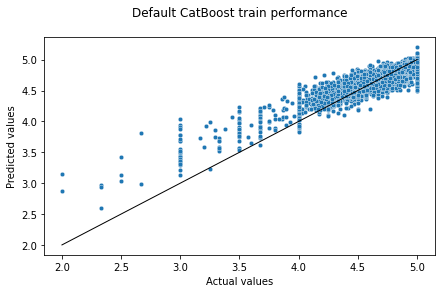

In [82]:
plot_predictions(default_model, X_train, y_train, 'Default CatBoost train performance')

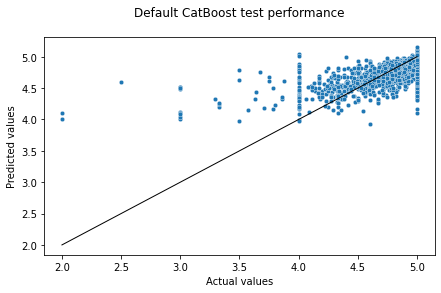

In [83]:
plot_predictions(default_model, X_test, y_test, 'Default CatBoost test performance')

In [84]:
tree_num = default_model._tree_count

if tree_num != default_model.get_all_params()['iterations']:
    
    default_model = CatBoostRegressor(random_state = 20202020, 
                                  learning_rate = 0.03,
                                  iterations = tree_num,
                                  cat_features = categorical_features,
                                  one_hot_max_size = 20,
                                  verbose = 100)
    default_model.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = False)

### SHAP & feature statistics

In [85]:
from catboost import Pool
import shap
shap.initjs()

In [86]:
train_pool = Pool(X_train, y_train, 
                  cat_features = categorical_features)

test_pool = Pool(X_test, y_test, 
                  cat_features = categorical_features)

In [87]:
#default_model.calc_feature_statistics(train_pool)

In [88]:
shap_values = default_model.get_feature_importance(train_pool, type = 'ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [89]:
print('Predicted value:', default_model.predict(X_train)[10])
print('Actual value:', y_train.iloc[10])

Predicted value: 4.8061597345598095
Actual value: 5.0


In [90]:
shap.force_plot(expected_value, shap_values[10,:], X_train.iloc[10,:])

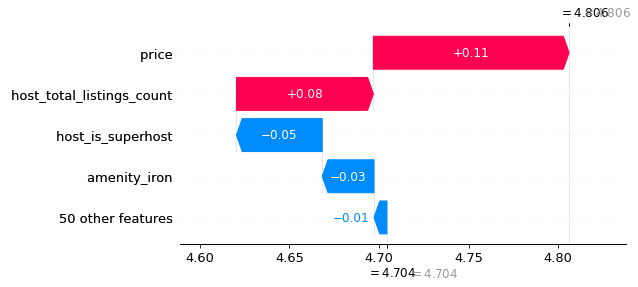

In [91]:
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[10], X_train.iloc[10,:], max_display = 5)

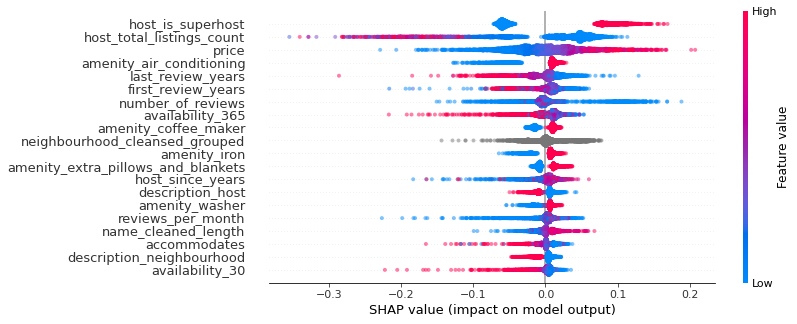

In [92]:
shap.summary_plot(shap_values, X_train, plot_type = 'dot', plot_size = (10, 5), alpha = 1/2)

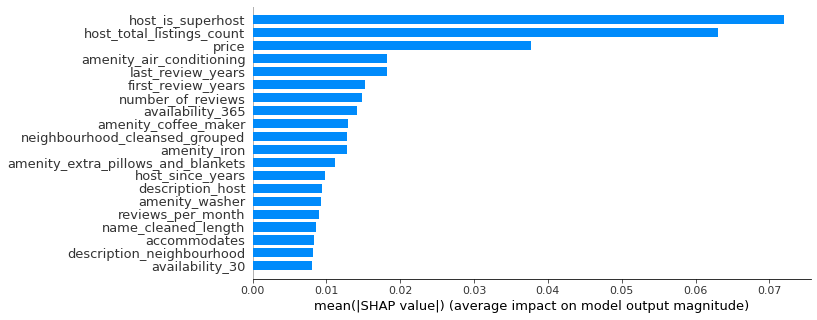

In [93]:
shap.summary_plot(shap_values, X_train, plot_type = 'bar', plot_size = (10, 5))

In [94]:
# for name in X_test.columns.tolist(): #[i for i in X_test.columns.tolist() if i not in categorical_features]:
#     shap.dependence_plot(name, shap_values, X_train, dot_size = 20, alpha = 1/2)

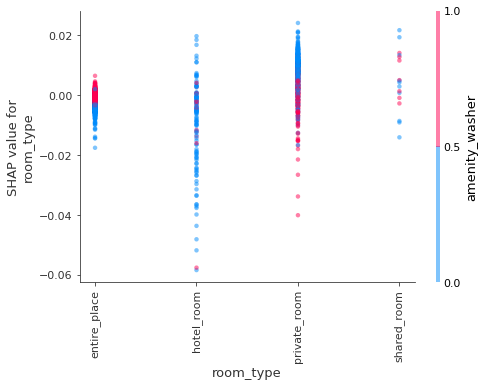

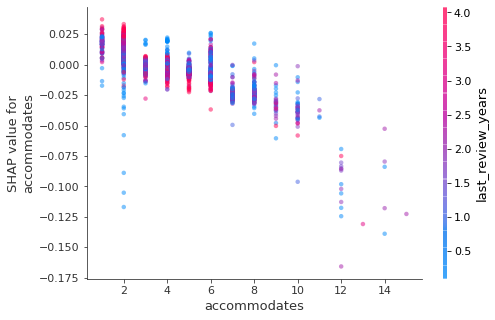

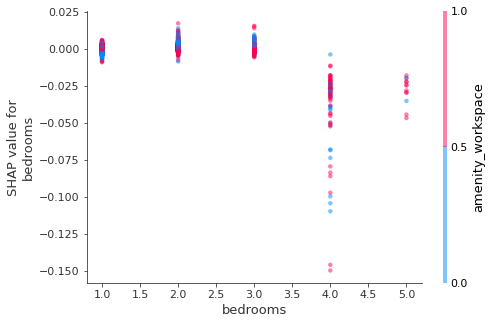

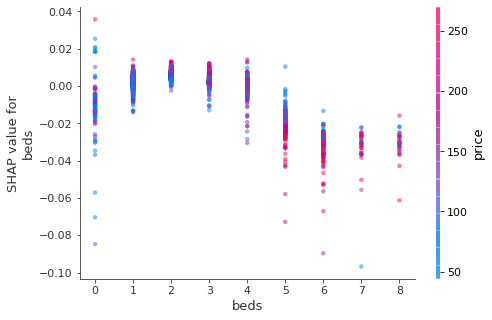

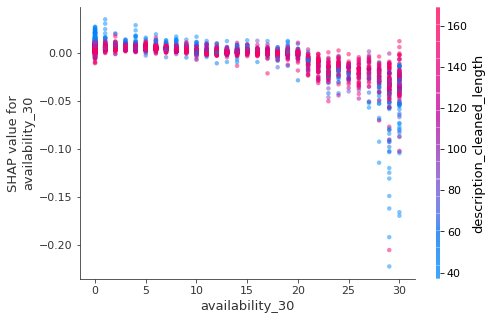

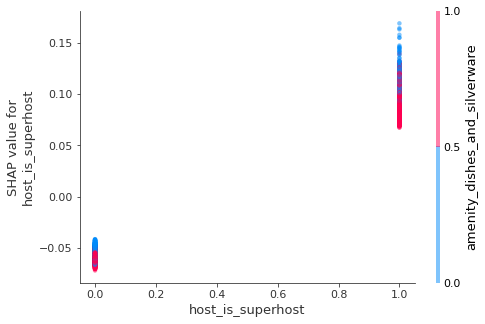

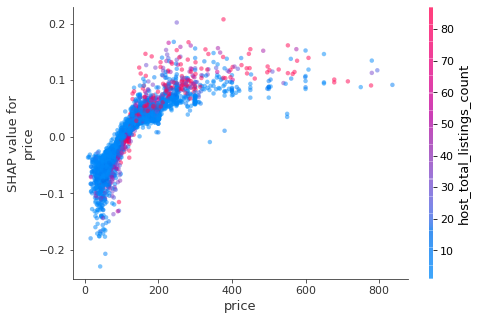

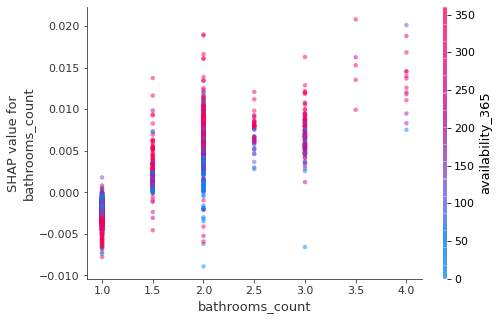

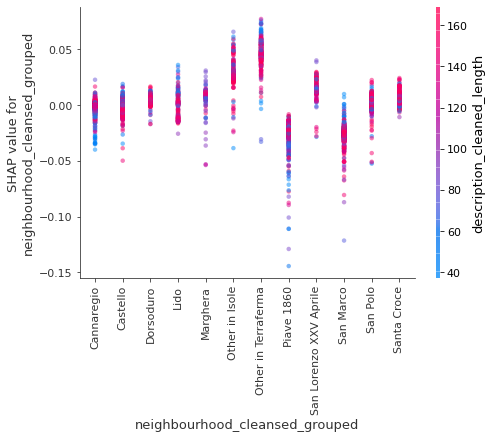

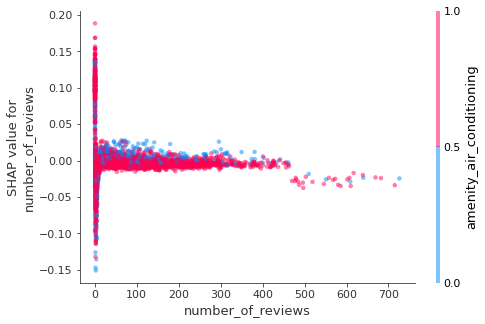

In [95]:
check_dependecy_plots = ['room_type', 'accommodates', 'bedrooms', 'beds', 'availability_30', 'host_is_superhost', 
                         'price', 'bathrooms_count', 'neighbourhood_cleansed_grouped', 'number_of_reviews']
check_dependecy_plots = [i for i in check_dependecy_plots if i in X_train.columns]

for name in check_dependecy_plots: #[i for i in X_test.columns.tolist() if i not in categorical_features]:
    shap.dependence_plot(name, shap_values, X_train, dot_size = 20, alpha = 1/2)